# Homework 4

In [1]:
import yfinance as yf 
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
pd.options.mode.chained_assignment = None

In [2]:
data = yf.download('^GSPC','2020-09-30','2022-10-01')
data.to_csv("SP500.csv")
data = data.drop(["Open", "High", "Low", "Adj Close", "Volume"], axis = 1)
data

[*********************100%***********************]  1 of 1 completed


,Close
Date,
2020-09-30,3363.000000
2020-10-01,3380.800049
2020-10-02,3348.419922
2020-10-05,3408.600098
2020-10-06,3360.969971
...,...
2022-09-26,3655.040039
2022-09-27,3647.290039
2022-09-28,3719.040039


### Question 1 (10%)
Please find the volatility of S&P500 and plot the graph of close price.

Volitility: Close    0.011516
dtype: float64


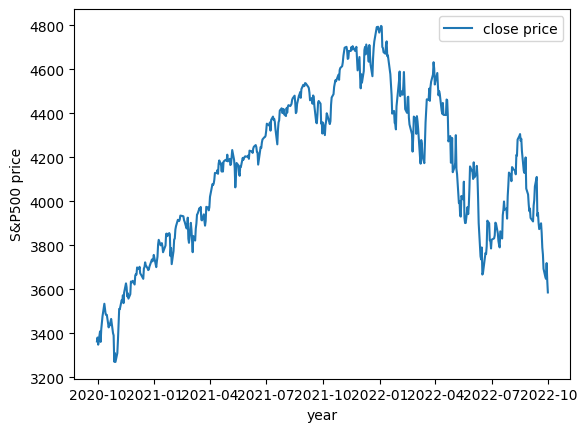

In [3]:
close_price = data
daily_updown = close_price.diff()
daily_updown.iloc[1:] = close_price.diff().iloc[1:].to_numpy() / close_price.iloc[:len(close_price) - 1].to_numpy()

print("Volitility:", daily_updown.std())
plt.plot(close_price, label = "close price")
plt.legend()
plt.xlabel("year")
plt.ylabel("S&P500 price")
plt.show()

### Question 2 (30%)
Set basis cost = $15$, leverage = $10$, trading frequency = $30$, data = data and other parameters as default.  
Please implement the following backtest function and 
1. Compute internal rate of return
2. plot the equity curve. 


*Feel free to add any other attributes or functions to help you implement your backtest function.*

In [4]:
class backtest:
    def __init__(self, basis_cost = 15, trading_fee_rate = 0.0005, init_capital = 50000, leverage = 10, trading_frequency = 30, data = None):
        self.basis_cost = basis_cost
        self.trading_fee_rate = trading_fee_rate
        self.init_capital = init_capital
        self.leverage = leverage
        self.trading_frequency = trading_frequency

        self.data = data.copy()
        self.data["adj close after change position"] = 0 
        self.data["adj weight"] = 0
        self.data["position"] = 0
        self.data["total value"] = init_capital * leverage
        self.data["equity"] = init_capital

    def compute(self, x, df, basis_cost, trading_fee_rate, leverage, if_last = False):
        ## calculate the first capital
        trading_fee = df["equity"][x.index[0]] * leverage * trading_fee_rate / (1 + leverage * trading_fee_rate)
        df["equity"][x.index[0]] -= trading_fee
        ## update data
        df["adj close after change position"].loc[x.index] = df["Close"].loc[x.index] + basis_cost * df["adj weight"].loc[x.index]

        df["position"].loc[x.index] = df["equity"].loc[x.index[0]] * leverage / (df["adj close after change position"].loc[x.index[0]])
        df["total value"].loc[x.index] = df["position"].loc[x.index] * df["Close"].loc[x.index]
        df["equity"].loc[x.index[0]] += df["total value"].loc[x.index[0]] -  df["equity"].loc[x.index[0]] * leverage
        
        df["equity"].loc[x.index] = df["total value"].loc[x.index] - df["total value"][x.index[0]] + df["equity"][x.index[0]]
        if if_last:
            df["equity"].loc[x.index[-1]] -= df["total value"].loc[x.index[-1]] * trading_fee_rate
            
        else:
            df["equity"].loc[x.index[-2]] -= df["total value"].loc[x.index[-2]] * trading_fee_rate
            df["equity"].loc[x.index[-1]] = df["equity"].loc[x.index[-2]]
            df["adj weight"].loc[x.index[-1]] = 1

        # print("================================================")
        # print(x.index[0])
        # print(x.index[-1])

        return 0

    def backtest(self):
        capital = self.init_capital
        self.data["Close"].rolling(self.trading_frequency, step=self.trading_frequency, closed="both").apply(lambda x: self.compute(x, self.data, self.basis_cost, self.trading_fee_rate, self.leverage))
        if (len(self.data) % self.trading_frequency > 1):
            self.data["Close"].iloc[-1 * (len(self.data) % self.trading_frequency) - 1:].rolling(len(self.data) % self.trading_frequency, step=len(self.data) % self.trading_frequency, closed="right").apply(lambda x:self.compute(x, self.data, self.basis_cost, self.trading_fee_rate, self.leverage, if_last=True))
        for i in range(len(self.data)):
            if self.data["equity"][i] <= 0:
                self.data[i:] = 0
        

-1.0


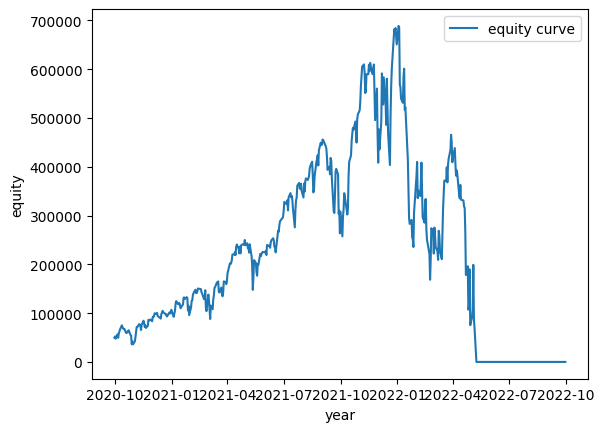

In [5]:
b = backtest(data=data, leverage=10)
b.backtest()
print((1 + (b.data["equity"][-1] - b.init_capital) / b.init_capital) ** (1/2) - 1)
plt.plot(b.data["equity"], label="equity curve")
plt.legend()
plt.xlabel("year")
plt.ylabel("equity")
plt.show()

### Question 3 (10%)
Try different leverages (1, 5, 10) and trading frequencies (7, 30, 90). Find the relationship between those parameters and the equity curve.

----------leverage----------
leverage: 1 APY: 0.024478669164063493


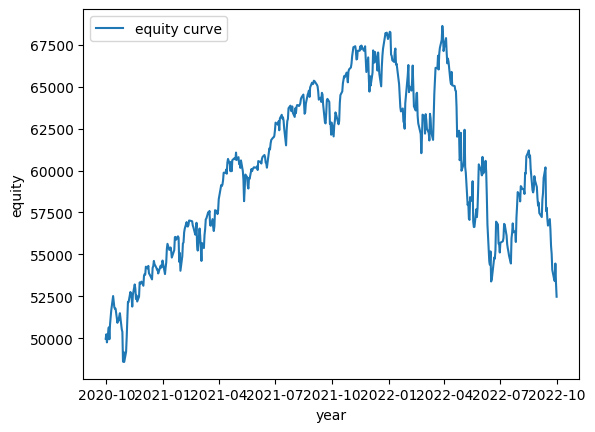

leverage: 5 APY: -0.1963812456848265


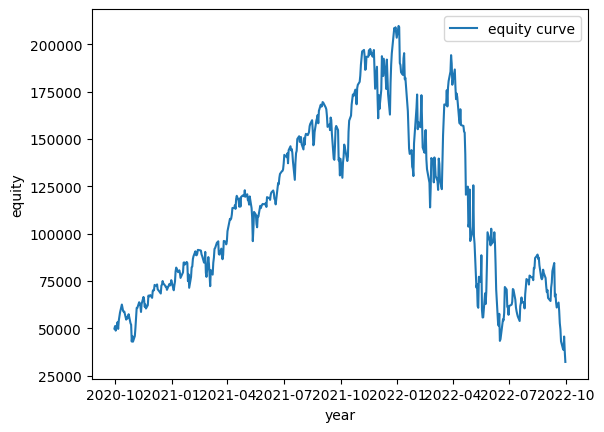

leverage: 10 APY: -1.0


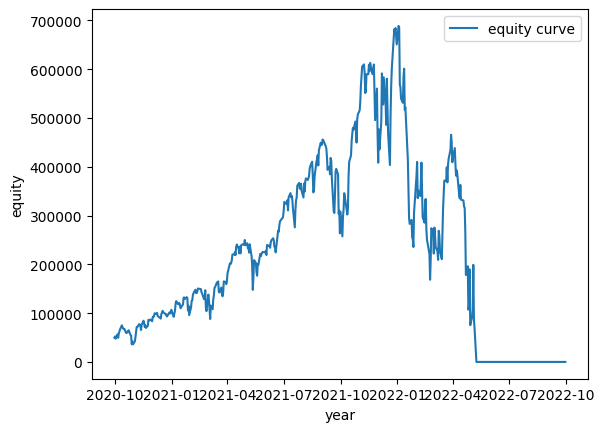

----------frequency----------
frequency: 7 APY: -0.83216705620036


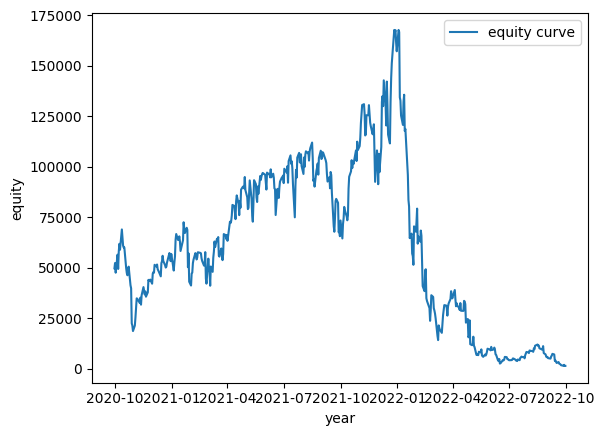

frequency: 30 APY: -1.0


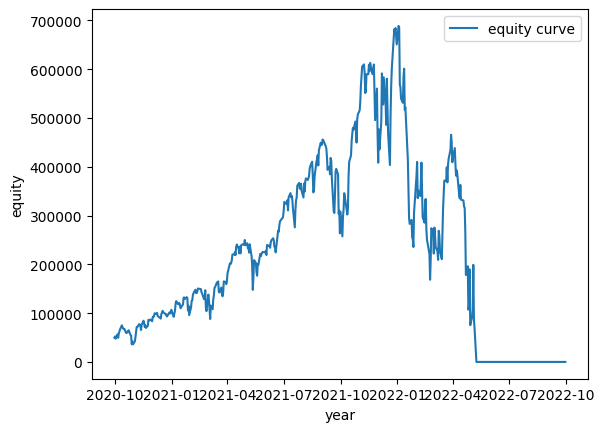

frequency: 90 APY: -1.0


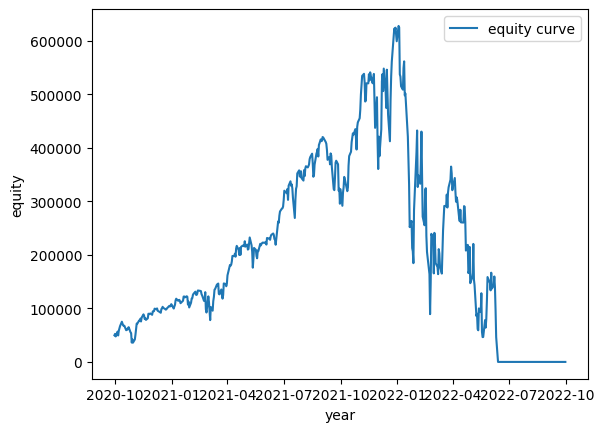

In [6]:
leverages = [1, 5, 10]
frequencies = [7, 30, 90]

print("----------leverage----------")
for l in leverages:
    b = backtest(leverage = l, data=data)
    b.backtest()
    print("leverage:", l, "APY:", (1 + (b.data["equity"][-1] - b.init_capital) / b.init_capital) ** (1/2) - 1)
    b.data.to_csv(f"reference_leverage{l}.csv")
    plt.plot(b.data["equity"], label="equity curve")
    plt.legend()
    plt.xlabel("year")
    plt.ylabel("equity")
    plt.show()
print("----------frequency----------")
for f in frequencies:
    b = backtest(trading_frequency = f, data=data)
    b.backtest()
    
    print("frequency:", f, "APY:", (1 + (b.data["equity"][-1] - b.init_capital) / b.init_capital) ** (1/2) - 1)
    b.data.to_csv(f"reference_frequency{f}.csv")
    plt.plot(b.data["equity"], label="equity curve")
    plt.legend()
    plt.xlabel("year")
    plt.ylabel("equity")
    plt.show()


### Question 4 (30%)
Set the parameters as default. Compute the APY with different leverage.

In [7]:
APY = []
leverages = []
for l in range(91):
    leverages.append(1 + l/10)
    b = backtest(leverage = 1 + l/10, trading_frequency = 30, data=data)
    b.backtest()
    APY.append((1 + (b.data["equity"][-1] - b.init_capital) / b.init_capital) ** (1/2) - 1)

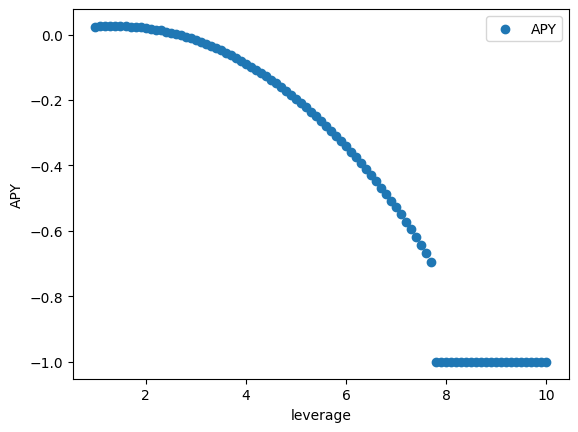

In [8]:
plt.scatter(leverages, APY, label = "APY")
plt.legend()
plt.xlabel("leverage")
plt.ylabel("APY")
plt.show()

### Question 5 (20%)
Randomly sort the daily up/down and check if the order of daily up/down could influence the backtest performance.

In [9]:
close_price = data["Close"]
daily_updown = close_price.diff()
daily_updown.iloc[1:] = close_price.diff().iloc[1:].to_numpy() / close_price.iloc[:len(close_price) - 1].to_numpy()
daily_updown[0] = 0
data["updown"] = daily_updown
data[1:] = data[1:].sample(frac=1).reset_index(drop=True)
for i in range(1, len(data)):
    data["Close"][i] = data["Close"][i - 1] * (1 + data["updown"][i])
data

,Close,updown
Date,,
2020-09-30,3363.000000,0.000000
2020-10-01,3443.008338,0.023791
2020-10-02,3442.017732,-0.000288
2020-10-05,3461.630132,0.005698
2020-10-06,3475.983367,0.004146
...,...,...
2022-09-26,3483.569264,-0.012130
2022-09-27,3522.496679,0.011175
2022-09-28,3565.236324,0.012133


### Bonus (10%)
After applying the Monte Carlo method. Please find out a threshold of leverage where only 5% of the equity curve has MDD > 20%

## Submission
Please write a report for those questions. Submit your report and code to NTU Cool.

Format:
* {student_id}_report.pdf
* {student_id}_code.ipynb